In [93]:
from mpl_toolkits.mplot3d import axes3d # 3D figure
import matplotlib.pyplot as plt
plt.ion()
%matplotlib widget

from matplotlib import cm
from matplotlib import rc
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import math
import scipy.interpolate as interpolate
import scipy.signal as signal
from scipy.optimize import curve_fit

from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as tck
import scipy.io as sio
import pandas as pd
import matplotlib.ticker as ticker

import os

from pylab import *
from numpy import *
from matplotlib.widgets import Button
from matplotlib import rc

import sys
from xlsx2csv import Xlsx2csv
import glob
import csv
params={'axes.labelsize':20,'xtick.labelsize':15,'ytick.labelsize':15}
rcParams.update(params)

In [94]:
# Colour Palette
rcParams["axes.prop_cycle"]=cycler(color=['#68246D', '#FFD53A', '#00AEEF', '#BE1E2D', '#AFA961'])

## Load data

### 20220412 data

In [95]:
df = pd.read_csv('Data/Data PML/datafolder/20220412_163417_temperature.csv')

In [96]:
# # Name columns
df.columns = ['Memory', 'Reference']

In [97]:
Rb_spectrum = df.iloc[::-1].reset_index(drop=True)

### 20230928 data

In [98]:
# # Load data as pandas dataframe
# Rb_spectrum = pd.read_csv('Data/Data PML/datafolder/20230928/od-cellTemp116.csv', index_col=False)

# # Name the columns
# Rb_spectrum.columns = ['Time', 'Reference', 'Memory', 'void']

## Inspect data

### 20220412 data

In [99]:
Time = df.index
Rb_spectrum_memory = Rb_spectrum['Memory']
Rb_spectrum_reference = Rb_spectrum['Reference']


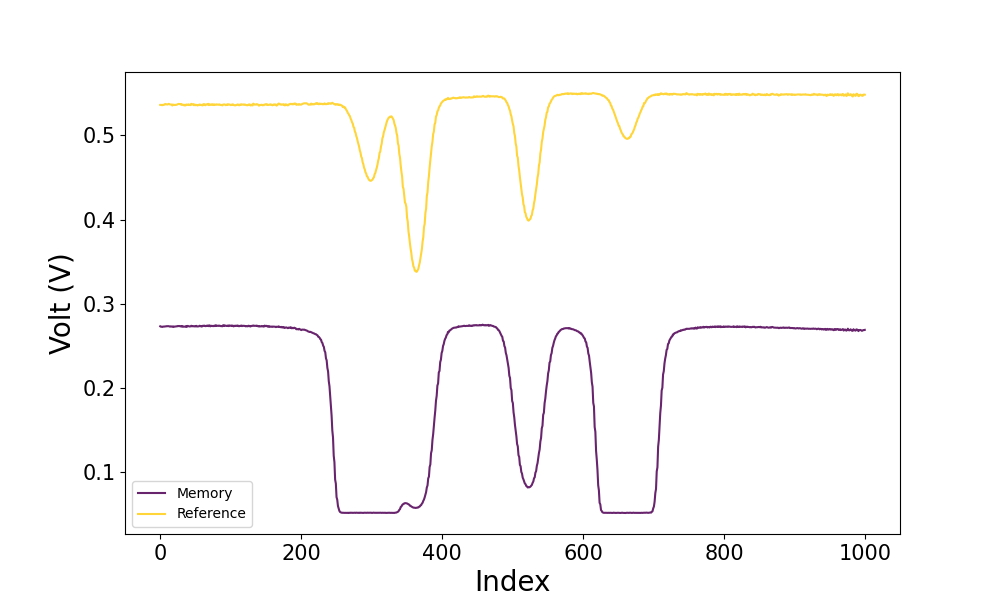

In [100]:
# Plot index vs reference and memory
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Time, Rb_spectrum_memory, label='Memory')
ax.plot(Time, Rb_spectrum_reference, label='Reference')
ax.set_xlabel('Index')
ax.set_ylabel('Volt (V)')
ax.legend()
plt.show()




### 20230928 data

In [101]:
# Rb_spectrum.drop(columns=['void'], inplace=True)
# # Drop the first row
# Rb_spectrum.drop([0], inplace=True)

In [102]:
# Time = Rb_spectrum['Time'].astype(float)
# Rb_spectrum_reference = Rb_spectrum['Reference'].astype(float)
# Rb_spectrum_memory = Rb_spectrum['Memory'].astype(float)


In [103]:
# # Plot data
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# ax.plot(Time, Rb_spectrum_reference, label='Reference')
# ax.plot(Time, Rb_spectrum_memory, label='Memory')
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Voltage (V)')
# ax.legend()
# ax.set_title('Rb Spectrum')
# plt.show()


## Crop data

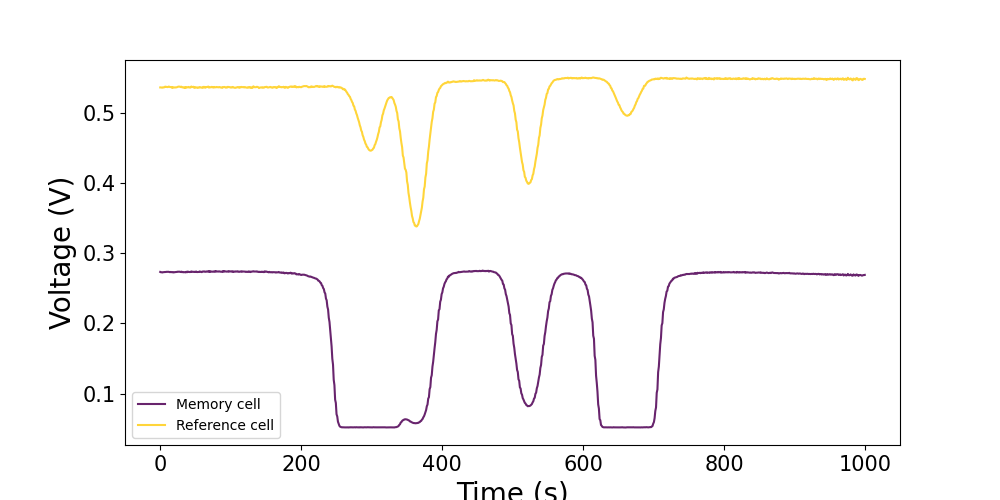

In [104]:
# Crop data
crop_start = int(0/100 * len(Time))
crop_end = int(100/100 * len(Time))

Rb_spectrum_memory_cropped = Rb_spectrum_memory[crop_start:crop_end]
Rb_spectrum_reference_cropped = Rb_spectrum_reference[crop_start:crop_end]
Time_cropped = Time[crop_start:crop_end]

# Reset index
# Time_cropped = Time_cropped.reset_index(drop=True)

Time_cropped = Time_cropped - Time_cropped[0]

# Plot data
plt.figure(figsize=(10,5))
plt.plot(Time_cropped, Rb_spectrum_memory_cropped, label='Memory cell')
plt.plot(Time_cropped, Rb_spectrum_reference_cropped, label='Reference cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

## Map to frequency domain

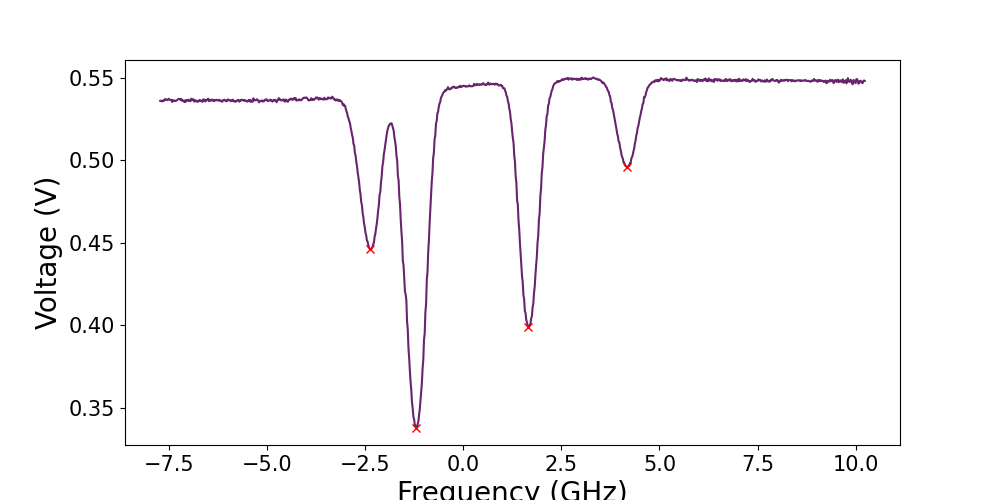

Detuning of fit from actual frequencies in MHz:  [ -4.00165895  30.62244948 -17.74319296  24.29334828]


In [105]:
# Convert to frequency space
_Rb87F1 = 4.15; _Rb85F2 = 1.675; _Rb85F3 = -1.232; _Rb87F2 = -2.366


freq_Rb = np.array([_Rb87F2, _Rb85F3, _Rb85F2, _Rb87F1])



# Smoothen data before finding dips
# Rb_spectrum_reference_smooth = signal.savgol_filter(Rb_spectrum_reference_cropped, 100, 2)
Rb_spectrum_reference_smooth = Rb_spectrum_reference_cropped




# Find the dips in the reference cell data 
dips_reference, _ = signal.find_peaks(-Rb_spectrum_reference_smooth, prominence = 0.007, distance=10)

# Linear fit to the dips
freq_array = np.polyval(np.polyfit(dips_reference, freq_Rb, 1), np.linspace(0, len(Rb_spectrum_reference_smooth), len(Rb_spectrum_reference_smooth)))
   

# Plot dips
plt.figure(figsize=(10,5))
# plt.plot(Time_cropped, Rb_spectrum_reference_smooth)
# plt.plot(Time_cropped[dips_reference], Rb_spectrum_reference_smooth[dips_reference], 'x', label='Dips', color='red')
plt.plot(freq_array, Rb_spectrum_reference_smooth, label='Reference cell')
plt.plot(freq_array[dips_reference], Rb_spectrum_reference_smooth[dips_reference], 'x', label='Dips', color='red')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Voltage (V)')
plt.show()

# Get detuning of fit from actual frequencies
detuning = freq_array[dips_reference] - freq_Rb
print('Detuning of fit from actual frequencies in MHz: ', detuning*10**3)


## Normalise data

### Reference cell

#### Normalise for subset

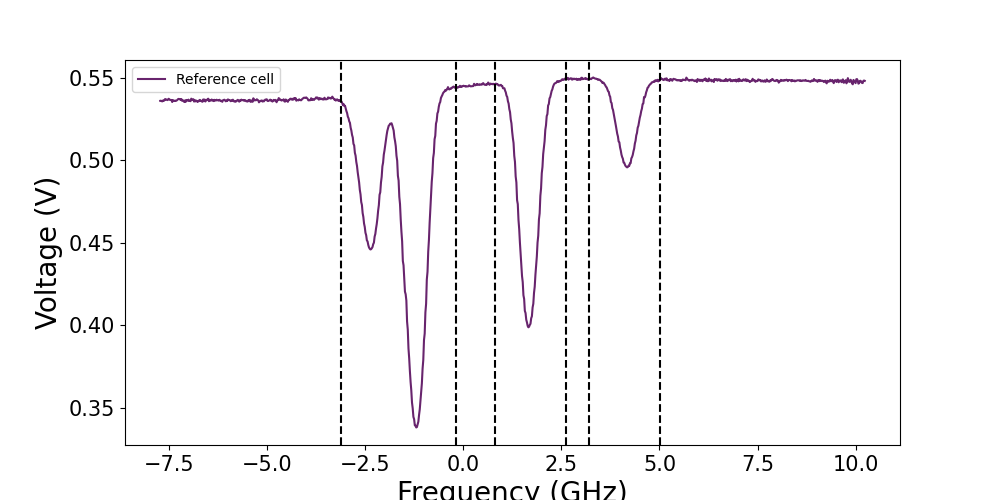

In [106]:
# Define transmission regions
point_A = np.where(freq_array > -3.13)[0][0]
point_B = np.where(freq_array > -0.2)[0][0]
point_C = np.where(freq_array > 0.8)[0][0]
point_D = np.where(freq_array > 2.6)[0][0]
point_E = np.where(freq_array > 3.2)[0][0]
point_F = np.where(freq_array > 5)[0][0]

# Plot with points
plt.figure(figsize=(10, 5))
plt.plot(freq_array, Rb_spectrum_reference_smooth, label='Reference cell')
plt.axvline(x=freq_array[point_A], color='k', linestyle='--')
plt.axvline(x=freq_array[point_B], color='k', linestyle='--')
plt.axvline(x=freq_array[point_C], color='k', linestyle='--')
plt.axvline(x=freq_array[point_D], color='k', linestyle='--')
plt.axvline(x=freq_array[point_E], color='k', linestyle='--')
plt.axvline(x=freq_array[point_F], color='k', linestyle='--')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

#### Normalise for whole data set

In [107]:

# point_A = np.where(Time > -0.11)[0][0]
# point_B = np.where(Time > -0.091)[0][0]
# point_C = np.where(Time > -0.083)[0][0]
# point_D = np.where(Time > -0.072)[0][0]
# point_E = np.where(Time > -0.066)[0][0]
# point_F = np.where(Time > -0.056)[0][0]

# turnover = np.where(Time > -0.052)[0][0]

# non_lin_param = 1.1
# mirror_point_A = int(np.abs((point_A - turnover))*non_lin_param) + turnover
# mirror_point_B = int(np.abs((point_B - turnover))*non_lin_param) + turnover
# mirror_point_C = int(np.abs((point_C - turnover))*non_lin_param) + turnover
# mirror_point_D = int(np.abs((point_D - turnover))*non_lin_param) + turnover
# mirror_point_E = int(np.abs((point_E - turnover))*non_lin_param) + turnover
# mirror_point_F = int(np.abs((point_F - turnover))*non_lin_param) + turnover

# # Mirror points are a bit off, probably because off imprecise frequency mapping and/or gain in diode


# # Plot with points
# plt.figure(figsize=(10, 5))
# plt.plot(Time, Rb_spectrum_reference[:,1], label='Reference cell')
# plt.axvline(x=Time[point_A], color='k', linestyle='--')
# plt.axvline(x=Time[point_B], color='k', linestyle='--')
# plt.axvline(x=Time[point_C], color='k', linestyle='--')
# plt.axvline(x=Time[point_D], color='k', linestyle='--')
# plt.axvline(x=Time[point_E], color='k', linestyle='--')
# plt.axvline(x=Time[point_F], color='k', linestyle='--')
# plt.axvline(x=Time[turnover], color='r', linestyle='--')
# plt.axvline(Time[mirror_point_A], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_B], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_C], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_D], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_E], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_F], color='g', linestyle='--')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel('Voltage (V)')
# plt.legend()
# plt.show()

#### Apply normalisation

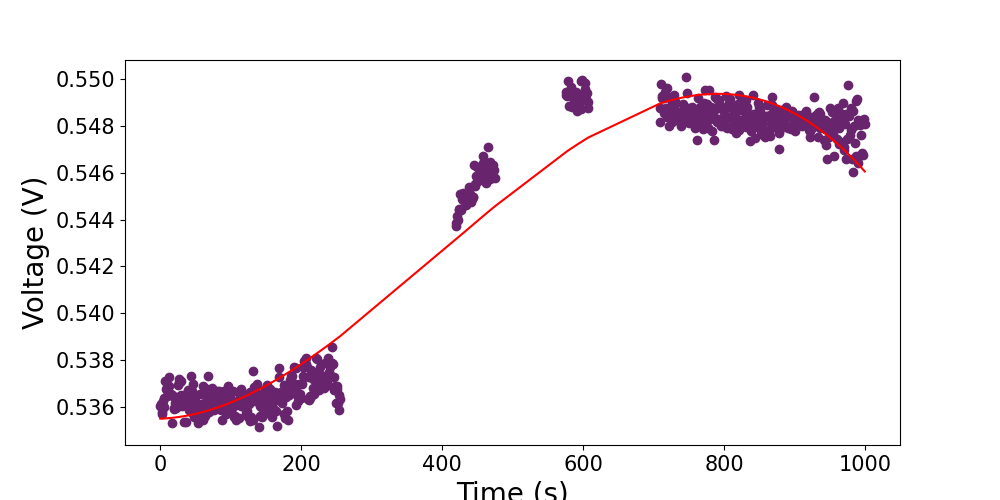

In [108]:
# Take data corresponding to off-resonant frequencies for reference

# For subset
transmission_a_reference = Rb_spectrum_reference_cropped[:point_A]
transmission_b_to_c_reference = Rb_spectrum_reference_cropped[point_B:point_C]
transmission_d_to_e_reference = Rb_spectrum_reference_cropped[point_D:point_E]
transmission_f_reference = Rb_spectrum_reference_cropped[point_F:]

# For whole data set
# transmission_a_reference = Rb_spectrum_reference[:point_A, 1]
# transmission_b_to_c_reference = Rb_spectrum_reference[point_B:point_C, 1]
# transmission_d_to_e_reference = Rb_spectrum_reference[point_D:point_E, 1]
# transmission_f_reference = Rb_spectrum_reference[point_F:mirror_point_F, 1]
# transmission_e_to_d_reference = Rb_spectrum_reference[mirror_point_E:mirror_point_D, 1]
# transmission_c_to_b_reference = Rb_spectrum_reference[mirror_point_C:mirror_point_B, 1]
# transmission_a_m_reference = Rb_spectrum_reference[mirror_point_A:, 1]


# Bundle all transmissions together
# For subset
off_resonant_time_reference = np.concatenate([Time_cropped[:point_A], Time_cropped[point_B:point_C], Time_cropped[point_D:point_E], Time_cropped[point_F:]])
off_resonant_transmission_reference = np.concatenate([transmission_a_reference, transmission_b_to_c_reference, transmission_d_to_e_reference, transmission_f_reference])


# For whole data set
# off_resonant_time_reference = np.concatenate([Time[:point_A], Time[point_B:point_C], Time[point_D:point_E], Time[point_F:mirror_point_F], 
#                                             Time[mirror_point_E:mirror_point_D], Time[mirror_point_C:mirror_point_B], Time[mirror_point_A:]])

# off_resonant_transmission_reference = np.concatenate([transmission_a_reference, transmission_b_to_c_reference, transmission_d_to_e_reference, transmission_f_reference,
#                                                       transmission_e_to_d_reference,transmission_c_to_b_reference, transmission_a_m_reference])



# off_resonant_time_reference = np.concatenate([Time_cropped[:point_A], Time_cropped[point_B:point_C], Time_cropped[point_D:point_E], Time_cropped[point_F:]])
# off_resonant_transmission_reference = np.concatenate([Rb_spectrum_reference_smooth[:point_A], Rb_spectrum_reference_smooth[point_B:point_C], Rb_spectrum_reference_smooth[point_D:point_E], Rb_spectrum_reference_smooth[point_F:]])



# Apply polyfit to off resonant data
p_reference = np.polyfit(off_resonant_time_reference, off_resonant_transmission_reference, 3)


# Plot polyfit
plt.figure(figsize=(10, 5))
plt.scatter(off_resonant_time_reference, off_resonant_transmission_reference)
plt.plot(off_resonant_time_reference, np.polyval(p_reference, off_resonant_time_reference), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()





### Memory cell

#### Subset

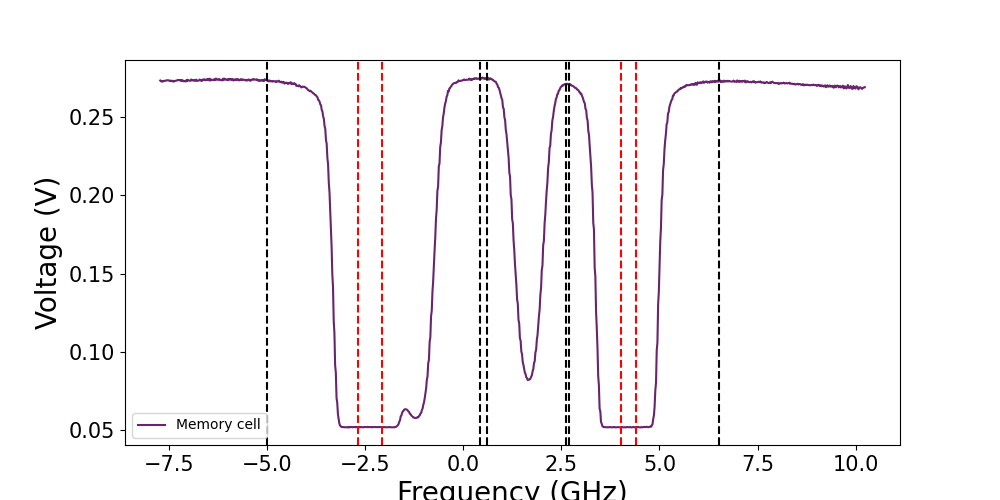

In [119]:
# Define transmission regions
point_A = np.where(freq_array > -5)[0][0]
point_B = np.where(freq_array > 0.4)[0][0]
point_C = np.where(freq_array > 0.6)[0][0]
point_D = np.where(freq_array > 2.6)[0][0]
point_E = np.where(freq_array > 2.7)[0][0]
point_F = np.where(freq_array > 6.5)[0][0]

zero_A = np.where(freq_array > -2.7)[0][0]
zero_B = np.where(freq_array > -2.1)[0][0]
zero_C = np.where(freq_array > 4.0)[0][0]
zero_D = np.where(freq_array > 4.4)[0][0]


# Plot with points
plt.figure(figsize=(10, 5))
plt.plot(freq_array, Rb_spectrum_memory_cropped, label='Memory cell')
plt.axvline(x=freq_array[point_A], color='k', linestyle='--')
plt.axvline(x=freq_array[point_B], color='k', linestyle='--')
plt.axvline(x=freq_array[point_C], color='k', linestyle='--')
plt.axvline(x=freq_array[point_D], color='k', linestyle='--')
plt.axvline(x=freq_array[point_E], color='k', linestyle='--')
plt.axvline(x=freq_array[point_F], color='k', linestyle='--')
plt.axvline(x=freq_array[zero_A], color='r', linestyle='--')
plt.axvline(x=freq_array[zero_B], color='r', linestyle='--')
plt.axvline(x=freq_array[zero_C], color='r', linestyle='--')
plt.axvline(x=freq_array[zero_D], color='r', linestyle='--')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

#### Data set

In [110]:

# point_A = np.where(Time > -0.118)[0][0]
# point_B = np.where(Time > -0.087)[0][0]
# point_C = np.where(Time > -0.084)[0][0]
# # point_D = np.where(Time > -0.072)[0][0]
# # point_E = np.where(Time > -0.066)[0][0]
# # point_F = np.where(Time > -0.056)[0][0]

# turnover = np.where(Time > -0.052)[0][0]

# non_lin_param = 1.1
# mirror_point_A = int(np.abs((point_A - turnover))*non_lin_param) + turnover
# mirror_point_B = int(np.abs((point_B - turnover))*non_lin_param) + turnover
# mirror_point_C = int(np.abs((point_C - turnover))*non_lin_param) + turnover
# mirror_point_D = int(np.abs((point_D - turnover))*non_lin_param) + turnover
# mirror_point_E = int(np.abs((point_E - turnover))*non_lin_param) + turnover
# mirror_point_F = int(np.abs((point_F - turnover))*non_lin_param) + turnover

# # Mirror points are a bit off, probably because off imprecise frequency mapping and/or gain in diode

# zero_A = np.where(Time > -0.109)[0][0]
# zero_B = np.where(Time > -0.102)[0][0]
# zero_C = np.where(Time > -0.063)[0][0]
# zero_D = np.where(Time > -0.059)[0][0]
# mirror_zero_A = int(np.abs((zero_A - turnover))*non_lin_param) + turnover
# mirror_zero_B = int(np.abs((zero_B - turnover))*non_lin_param) + turnover
# mirror_zero_C = int(np.abs((zero_C - turnover))*non_lin_param) + turnover
# mirror_zero_D = int(np.abs((zero_D - turnover))*non_lin_param) + turnover


# # Plot with points
# plt.figure(figsize=(10, 5))
# plt.plot(Time, Rb_spectrum_memory[:,1], label='Reference cell')
# plt.axvline(x=Time[point_A], color='k', linestyle='--')
# plt.axvline(x=Time[point_B], color='k', linestyle='--')
# plt.axvline(x=Time[point_C], color='k', linestyle='--')
# # plt.axvline(x=Time[point_D], color='k', linestyle='--')
# # plt.axvline(x=Time[point_E], color='k', linestyle='--')
# # plt.axvline(x=Time[point_F], color='k', linestyle='--')
# plt.axvline(x=Time[turnover], color='r', linestyle='--')
# plt.axvline(Time[mirror_point_A], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_B], color='g', linestyle='--')
# plt.axvline(Time[mirror_point_C], color='g', linestyle='--')
# # plt.axvline(Time[mirror_point_D], color='g', linestyle='--')
# # plt.axvline(Time[mirror_point_E], color='g', linestyle='--')
# # plt.axvline(Time[mirror_point_F], color='g', linestyle='--')
# plt.axvline(Time[zero_A], color='orange', linestyle='--')
# plt.axvline(Time[zero_B], color='orange', linestyle='--')
# plt.axvline(Time[zero_C], color='orange', linestyle='--')
# plt.axvline(Time[zero_D], color='orange', linestyle='--')
# plt.axvline(Time[mirror_zero_A], color='purple', linestyle='--')
# plt.axvline(Time[mirror_zero_B], color='purple', linestyle='--')
# plt.axvline(Time[mirror_zero_C], color='purple', linestyle='--')
# plt.axvline(Time[mirror_zero_D], color='purple', linestyle='--')
# plt.xlabel('Frequency (GHz)')
# plt.ylabel('Voltage (V)')
# plt.legend()
# plt.show()

### Adjust for y-axis offset

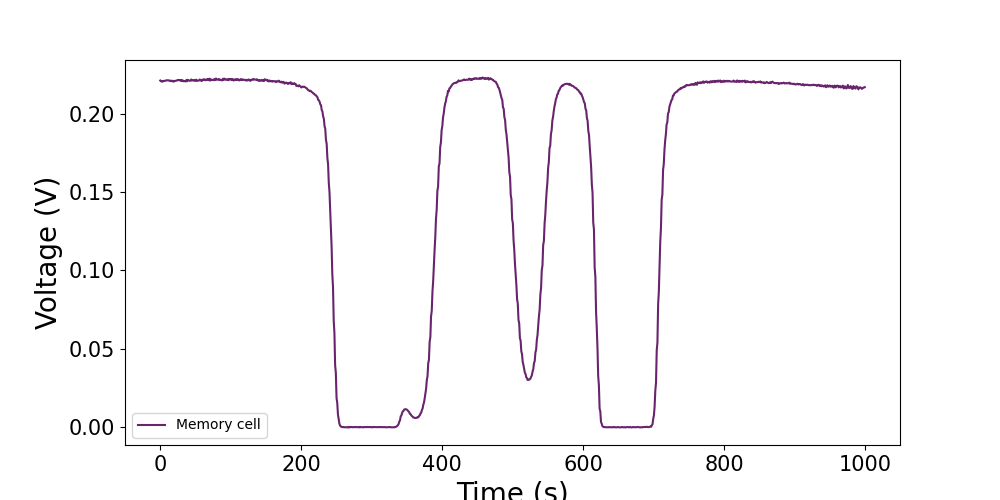

In [120]:
transmission_zero_a_to_b_memory = Rb_spectrum_memory_cropped[zero_A:zero_B]
transmission_zero_c_to_d_memory = Rb_spectrum_memory_cropped[zero_C:zero_D]

# Full data set
# tranmission_zero_m_d_to_c_memory = Rb_spectrum_memory[mirror_zero_D:mirror_zero_C, 1]
# transmission_zero_m_b_to_a_memory = Rb_spectrum_memory[mirror_zero_B:mirror_zero_A, 1]

# Sub set
zero_transmission_memory = np.concatenate([transmission_zero_a_to_b_memory, transmission_zero_c_to_d_memory])
zero_time_memory = np.concatenate([Time_cropped[zero_A:zero_B], Time_cropped[zero_C:zero_D]])

# Full data set
# zero_transmission_memory = np.concatenate([transmission_zero_a_to_b_memory, transmission_zero_c_to_d_memory, tranmission_zero_m_d_to_c_memory, transmission_zero_m_b_to_a_memory])
# zero_time_memory = np.concatenate([Time[zero_A:zero_B], Time[zero_C:zero_D], Time[mirror_zero_D:mirror_zero_C], Time[mirror_zero_B:mirror_zero_A]])

p_zero_memory = np.polyfit(zero_time_memory, zero_transmission_memory, 1)

mean_zero_transmission_memory = np.mean(zero_transmission_memory)

# Sub set
# Rb_spectrum_memory_zero = Rb_spectrum_memory_cropped - np.polyval(p_zero_memory, Time_cropped)
Rb_spectrum_memory_zero = Rb_spectrum_memory_cropped - mean_zero_transmission_memory





# Rb_spectrum_memory_smooth = signal.savgol_filter(Rb_spectrum_memory_zero, 100, 3)
Rb_spectrum_memory_smooth = Rb_spectrum_memory_zero
# No offset
# Rb_spectrum_memory_smooth = signal.savgol_filter(Rb_spectrum_memory_cropped[:,1], 100, 2)



# Plot polyfit
# plt.figure(figsize=(10, 5))
# plt.scatter(zero_time_memory, zero_transmission_memory)
# plt.plot(zero_time_memory, np.polyval(p_zero_memory, zero_time_memory), color='r')
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.show()

# Plot smoothed data
plt.figure(figsize=(10,5))
plt.plot(Time_cropped, Rb_spectrum_memory_smooth, label='Memory cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


### Adjust for power fluctuation

#### Subset

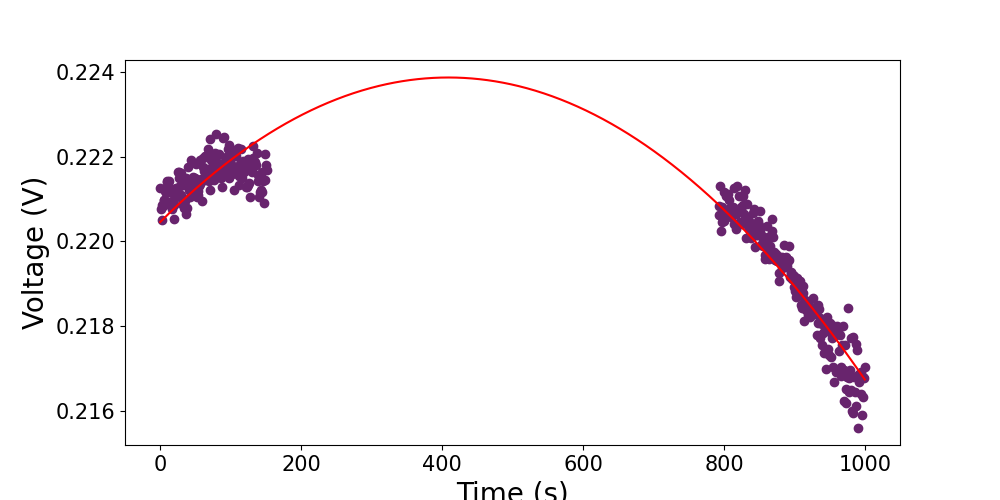

In [122]:
# Take data corresponding to off-resonant frequencies

transmission_a_memory = Rb_spectrum_memory_smooth[:point_A]
# transmission_b_to_c_memory = Rb_spectrum_memory_cropped[point_B:point_C]
# transmission_d_to_e_memory = Rb_spectrum_memory_cropped[point_D:point_E]
transmission_f_memory = Rb_spectrum_memory_smooth[point_F:]

# transmission_a_reference = Rb_spectrum_reference_cropped[:point_A, 1]
# transmission_b_to_c_reference = Rb_spectrum_reference_cropped[point_B:point_C, 1]
# transmission_d_to_e_reference = Rb_spectrum_reference_cropped[point_D:point_E, 1]
# transmission_f_reference = Rb_spectrum_reference_cropped[point_F:, 1]

# If no y-axis offset
# Rb_spectrum_memory_smooth = signal.savgol_filter(Rb_spectrum_memory[:, 1], 100, 2)


transmission_a_memory = Rb_spectrum_memory_smooth[:point_A]
transmission_b_to_c_memory = Rb_spectrum_memory_smooth[point_B:point_C]
transmission_d_to_e_memory = Rb_spectrum_memory_smooth[point_D:point_E]
transmission_f_memory = Rb_spectrum_memory_smooth[point_F:]

# Long range
off_resonant_time_memory = np.concatenate([Time_cropped[:point_A], Time_cropped[point_F:]])
off_resonant_transmission_memory = np.concatenate([transmission_a_memory, transmission_f_memory])

# off_resonant_time_memory = np.concatenate([Time_cropped[:point_A], Time_cropped[point_B:point_C], Time_cropped[point_D:point_E], Time_cropped[point_F:]])
# off_resonant_transmission_memory = np.concatenate([Rb_spectrum_memory_smooth[:point_A], Rb_spectrum_memory_smooth[point_B:point_C], Rb_spectrum_memory_smooth[point_D:point_E], Rb_spectrum_memory_smooth[point_F:]])

# off_resonant_time_memory = Time_cropped[:point_A]
# off_resonant_transmission_memory = Rb_spectrum_memory_smooth[:point_A]







# Apply polyfit to off resonant data
p_memory = np.polyfit(off_resonant_time_memory, off_resonant_transmission_memory, 2)


# Plot polyfit
plt.figure(figsize=(10, 5))
plt.scatter(off_resonant_time_memory, off_resonant_transmission_memory)
plt.plot(Time_cropped, np.polyval(p_memory, Time_cropped), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()







#### Data set

In [113]:
# # Take data corresponding to off-resonant frequencies for reference

# # If y-axis is corrected
# transmission_a_memory = Rb_spectrum_memory_zero[:point_A]
# transmission_a_m_memory = Rb_spectrum_memory_zero[mirror_point_A:]
# transmission_b_to_c_memory = Rb_spectrum_memory_zero[point_B:point_C]
# transmission_c_to_b_memory = Rb_spectrum_memory_zero[mirror_point_C:mirror_point_B]

# # transmission_a_memory = Rb_spectrum_memory[:point_A, 1]
# # transmission_a_m_memory = Rb_spectrum_memory[mirror_point_A:, 1]
# # transmission_b_to_c_memory = Rb_spectrum_memory[point_B:point_C, 1]
# # transmission_c_to_b_memory = Rb_spectrum_memory[mirror_point_C:mirror_point_B, 1]


# # Bundle all transmissions together
# # off_resonant_time_memory = np.concatenate([Time[:point_A], Time[mirror_point_A:]])
# # off_resonant_transmission_memory = np.concatenate([transmission_a_memory, transmission_a_m_memory])

# off_resonant_time_memory = np.concatenate([Time[:point_A], Time[point_B:point_C], Time[mirror_point_C:mirror_point_B], Time[mirror_point_A:]])
# off_resonant_transmission_memory = np.concatenate([transmission_a_memory, transmission_b_to_c_memory, transmission_c_to_b_memory, transmission_a_m_memory])







# # off_resonant_time_reference = np.concatenate([Time_cropped[:point_A], Time_cropped[point_B:point_C], Time_cropped[point_D:point_E], Time_cropped[point_F:]])
# # off_resonant_transmission_reference = np.concatenate([Rb_spectrum_reference_smooth[:point_A], Rb_spectrum_reference_smooth[point_B:point_C], Rb_spectrum_reference_smooth[point_D:point_E], Rb_spectrum_reference_smooth[point_F:]])



# # Apply polyfit to off resonant data
# p_memory = np.polyfit(off_resonant_time_memory, off_resonant_transmission_memory, 3)


# # Plot polyfit
# plt.figure(figsize=(10, 5))
# plt.scatter(off_resonant_time_memory, off_resonant_transmission_memory)
# plt.plot(Time, np.polyval(p_memory, Time), color='r')
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.show()





#### Normalise with fitted power profile

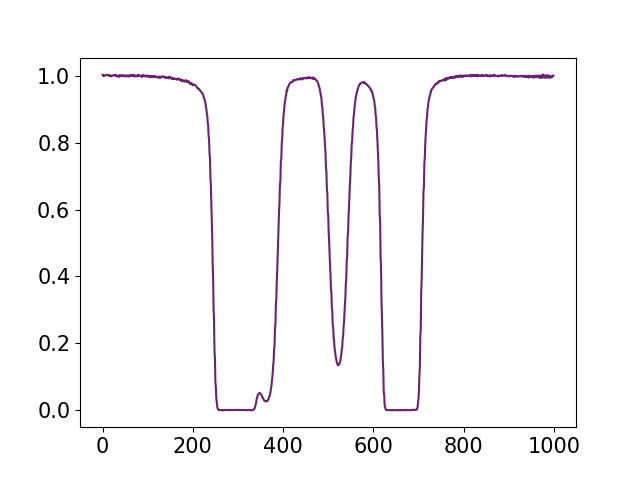

In [123]:

Rb_spectrum_memory_norm = Rb_spectrum_memory_smooth/np.polyval(p_memory, Time_cropped)

plt.figure()
plt.plot(Time_cropped, Rb_spectrum_memory_norm)
plt.show()



# Save to csv with first column as frequency and second column as transmission
# np.savetxt('Data/elecsus_cells_66C1_1_normalised.csv', np.column_stack((freq_array, Rb_spectrum_memory_norm)), delimiter=',')
# np.savetxt('Data/elecsus_cells_66C1_4_normalised.csv', np.column_stack((freq_array, Rb_spectrum_reference_norm)), delimiter=',')

#### Make sure that there is no negative absorption, ElecSus will fail otherwise

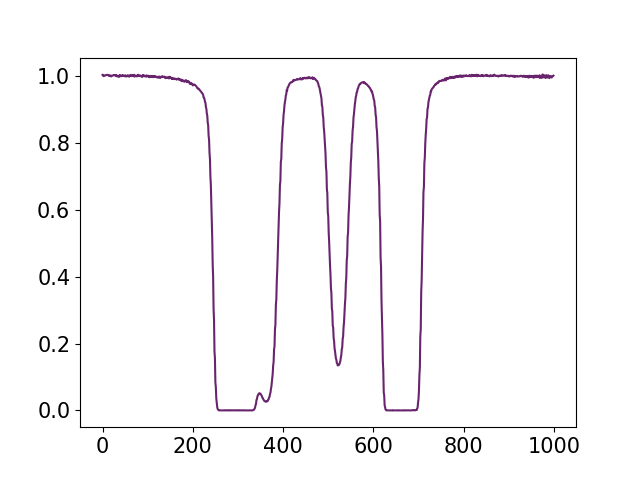

In [124]:
# Zero the dips
Rb_spectrum_memory_norm[np.where(Rb_spectrum_memory_norm <= 0)] = 0


plt.figure()
plt.plot(Time_cropped, Rb_spectrum_memory_norm)
plt.show()

#### Crop for ElecSus (for dataset), ElecSus only takes one absorption profile (up or down scans)

In [116]:
# # Crop data
# crop_start = int(0/100 * len(Time))
# crop_end = int(49.3/100 * len(Time))

# Rb_spectrum_memory_norm_crop = Rb_spectrum_memory_norm[crop_start:crop_end]
# # Rb_spectrum_reference_norm = Rb_spectrum_reference_norm[crop_start:crop_end]

# # Plot data
# plt.figure(figsize=(10,5))
# plt.plot(freq_array, Rb_spectrum_memory_norm_crop, label='Memory cell')
# # plt.plot(Time, Rb_spectrum_reference_norm, label='Reference cell')
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.legend()
# plt.show()

## ElecSus fit

In [125]:
# Fit ElecSus

import ElecSus_PQI.elecsus.elecsus_methods as EM

# Horizontal polarization
E_in=np.array([0,1,0])
E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
E_in=E_in_angle

# Cicular polarisation
# phase = np.pi
# E_in=np.array([1,1,0])
# E_in = [E_in[0], E_in[1]*np.exp(1.j*phase)]
# E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
# E_in = E_in_angle

groundPop = 0 # 0 for popShift, 1-7 for different F states. So far this is only hardcoded for Rb87

# popShift denotes the shift in population. If positive, lowest F state population is increased, if negative, lowest F state population is decreased

T = 70
# Initial values
p_dict_1 = {'Elem':'Rb','Dline':'D2','T':T,'lcell':80e-3, 'shift':0, 'Btheta':0,'Bfield':0,
            'shift':0,'Bphi':0,'GammaBuf':0, 'DoppTemp': T, 'rb85frac': 2, 'Constrain':True, 'popShift87': 0, 'popShift85':0}
p_dict_guess=p_dict_1

p_dict_bools={'T':True, 'DoppTemp':False, 'rb85frac': True, 'shift':True, 'popShift87':True, 'popShift85':True}

p_dict_bounds={}
p_dict_bounds['shift']=(-100, 100)
p_dict_bounds['rb85frac']=(0.5, 3.5)
p_dict_bounds['T']=(0, 130)
p_dict_bounds['popShift87']=(-5,5)
p_dict_bounds['popShift85']=(-5,5)

# p_dict_bounds['DoppTemp']=p_dict_bounds['T']


# Fit
best_params, RMS, result = EM.fit_data([freq_array*1e3, Rb_spectrum_memory_norm], p_dict_guess, p_dict_bools, groundPop,
                                       E_in, p_dict_bounds, data_type='S0',fit_algorithm='ML')

report = result.fit_report()
elecsus_fit = result.best_fit
print(report)


Starting parameter dictionary:
 {'Elem': 'Rb', 'Dline': 'D2', 'T': 70, 'lcell': 0.08, 'shift': 0, 'Btheta': 0, 'Bfield': 0, 'Bphi': 0, 'GammaBuf': 0, 'DoppTemp': 70, 'rb85frac': 2, 'Constrain': True, 'popShift87': 0, 'popShift85': 0}

Perfoming Marquardt-Levenberg fitting routine.
ML Fit completed
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1000
    # variables        = 5
    chi-square         = 0.28033954
    reduced chi-square = 2.8175e-04
    Akaike info crit   = -8169.50905
    Bayesian info crit = -8144.97027
    R-squared          = 0.99832988
[[Variables]]
    E_x:         0 (fixed)
    E_y:         1 (fixed)
    E_phase:     0 (fixed)
    T:           78.4634940 +/- 0.10433308 (0.13%) (init = 70)
    lcell:       0.08 (fixed)
    Bfield:      0 (fixed)
    Btheta:      0 (fixed)
    Bphi:        0 (fixed)
    GammaBuf:    0 (fixed)
    shift:       12.2242183 +/- 0.78837349 (6.45%) (

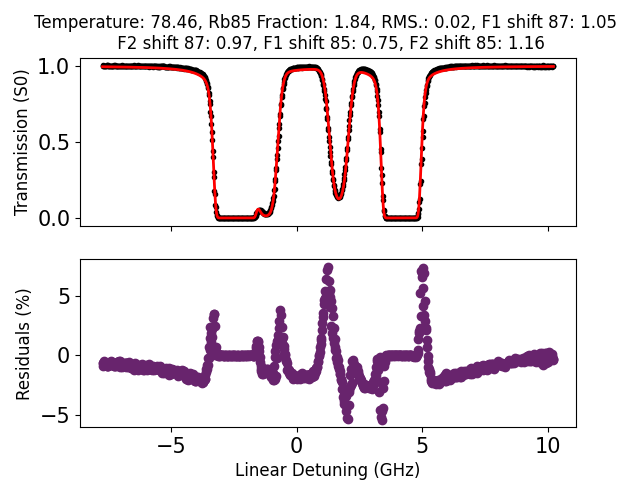

In [126]:
T_fit = best_params['T']
rb85frac_fit = best_params['rb85frac']
popShift_fit87 = best_params['popShift87']
popShift_fit85 = best_params['popShift85']
# For Rb87 get relative population of F1 and F2 states
hyperfine_frac_F1_87 = (3*(1+popShift_fit87/3))/(3*(1+popShift_fit87/3)+5*(1-popShift_fit87/5))
hyperfine_frac_F2_87 = (1-hyperfine_frac_F1_87)
hyperfine_frac_F1_87 = hyperfine_frac_F1_87/0.38
hyperfine_frac_F2_87 = hyperfine_frac_F2_87/(1-0.38)

# For Rb85 get relative population of F1 and F2 states
hyperfine_frac_F1_85 = (5*(1+popShift_fit85/5))/(5*(1+popShift_fit85/5)+8*(1-popShift_fit85/8))
hyperfine_frac_F2_85 = (1-hyperfine_frac_F1_85)
hyperfine_frac_F1_85 = hyperfine_frac_F1_85/(5/13)
hyperfine_frac_F2_85 = hyperfine_frac_F2_85/(1-5/13)


fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(freq_array,Rb_spectrum_memory_norm,'k.',label='Data')
# ax[0].plot(freq_array[dips_elecsus],elecsus_fit[dips_elecsus],'x', color='blue',label='Dips')
ax[0].plot(freq_array,elecsus_fit,'r-',lw=2,label='Fit')
ax[1].set_xlabel('Linear Detuning (GHz)', fontsize=12)
ax[0].set_ylabel('Transmission (S0)', fontsize=12)
ax[1].scatter(freq_array,100*(elecsus_fit-((Rb_spectrum_memory_norm))))
ax[1].set_ylabel('Residuals (%)', fontsize=12)
ax[0].title.set_text('Temperature: %.2f, Rb85 Fraction: %.2f, RMS.: %.2f, F1 shift 87: %.2f \n F2 shift 87: %.2f, F1 shift 85: %.2f, F2 shift 85: %.2f'% 
                    (T_fit, rb85frac_fit, RMS, hyperfine_frac_F1_87, hyperfine_frac_F2_87, hyperfine_frac_F1_85, hyperfine_frac_F2_85))
# Save image 
plt.savefig(f'/home/otps3141/Documents/Dokumente/ETH QE/Master Thesis Imperial/Thesis/Images/DRAGON/ElecSus/abs_mem_ref_PML_fit.png')
